## Text Generation

1. How to load an LLM from HuggingFace?
2. How to generate a token from the model output tensors?
3. Prefill and decode: optimizing token generation over multiple steps

### Import required packages

In [1]:
!pip install python-dotenv==1.0.0
!pip install torch==2.0.0
!pip install transformers==4.35.2
!pip install matplotlib==3.5.2
!pip install tqdm==4.64.1
!pip install openai==1.5.0  
!pip install accelerate==0.27.0
!pip install lorax-client==0.3.2

  Using cached matplotlib-3.5.2.tar.gz (35.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [671 lines of output]
      
      Edit mplsetup.cfg to change the build options; suppress output with --quiet.
      
      BUILDING MATPLOTLIB
            python: yes [3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]]
          platform: yes [darwin]
             tests: no  [skipping due to configuration]
            macosx: yes [installing]
      
      /Users/wenda/anaconda3/lib/python3.11/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
        

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

## 1. Load an LLM from HuggingFace?
- We will be using GPT2

In [3]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# model's architecture
print(model) 

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## 2. Generating a token from the model output tensors

### Text Generation
- Start by tokenizing the input prompt

In [4]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

Lets Pass the inputs to the model and retrieve the logits to find the most likely next token

In [5]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [6]:
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

In [7]:
tokenizer.decode(next_token_id)

' fence'

Lets print the 10 most likely next words

In [8]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [9]:
# Concatenate the input and most likely tokens
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


## 3. Prefill and decode: optimizing token generation over multiple steps
### Text generation helper function
- The following helper function generates the next tokens given a set of input tokens

In [10]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

* Use the helper function to generate multiple tokens in a loop
* Track the time it takes to generate each token

In [11]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

0.35964059829711914 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


- Plot token generation time
- The x-axis here is the token number
- The y-axis is the time to generate a token in millisenconds (ms)

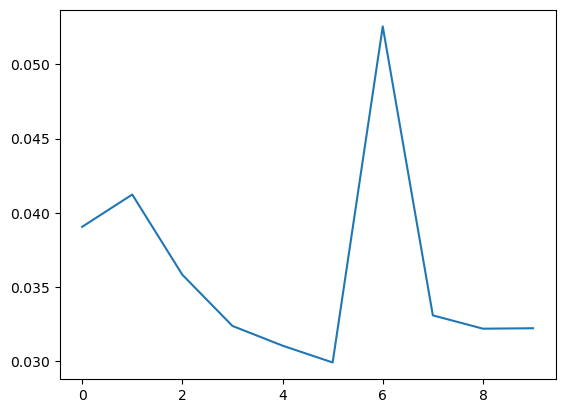

In [12]:
plt.plot(durations_s)
plt.show()

### Speeding up text generation with KV-caching
KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps
- Modify the generate helper function to return the next token and the key/value tensors

In [13]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [14]:
# Generate 10 tokens using the updated helper function
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.22383785247802734 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


Compare the execution time for the KV-cache function with the original helper function

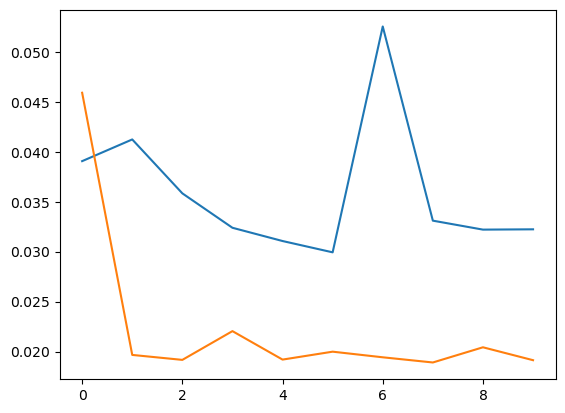

In [15]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()